### Regression Project: Boston House Prices

In this regression problem we are focusing on all of the required tasks from loading libraries untill make prediction on the validation dataset as a whole.

This is end to end project, with the following steps:

* Load libraries
* Load dataset
* Summarize data
* Data visualizations
* Prepare data
* Test harness
* Spot check algorithms
* Evaluate each model in turn
* Compare algorithms
* Scaled KNN algorithm tuning
* Spot check ensembes algorithms
* Evaluate each ensemble model in turn
* Compare ensemble algorithms
* Tune scaled ExtraTreeRegressor
* Make predictions on validation dataset
* Prepare the model
* Make prediction

ref.: https://github.com/gecso75/data/blob/main/housing.desc

#### Load libraries

In [1]:
import requests
import io
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import set_option
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#### Load dataset

In [2]:
url = "https://raw.githubusercontent.com/gecso75/data/main/housing.csv"
download = requests.get(url).content
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = read_csv(io.StringIO(download.decode('utf-8')), delim_whitespace=True, names=names)

#### Summarize data

In [3]:
df.shape

(506, 14)

In [4]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

all features are numeric

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [6]:
set_option('precision', 3)
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000
mean,3.614,11.364,11.137,0.069,0.555,6.285,68.575,3.795,9.549,408.237,18.456,356.674,12.653,22.533
std,8.602,23.322,6.860,0.254,0.116,0.703,28.149,2.106,8.707,168.537,2.165,91.295,7.141,9.197
min,0.006,0.000,0.460,0.000,0.385,3.561,2.900,1.130,1.000,187.000,12.600,0.320,1.730,5.000
25%,0.082,0.000,5.190,0.000,0.449,5.886,45.025,2.100,4.000,279.000,17.400,375.377,6.950,17.025
50%,0.257,0.000,9.690,0.000,0.538,6.208,77.500,3.207,5.000,330.000,19.050,391.440,11.360,21.200
75%,3.677,12.500,18.100,0.000,0.624,6.623,94.075,5.188,24.000,666.000,20.200,396.225,16.955,25.000
max,88.976,100.000,27.740,1.000,0.871,8.780,100.000,12.127,24.000,711.000,22.000,396.900,37.970,50.000


#### Data visualizations

_Let us see data skewness:_

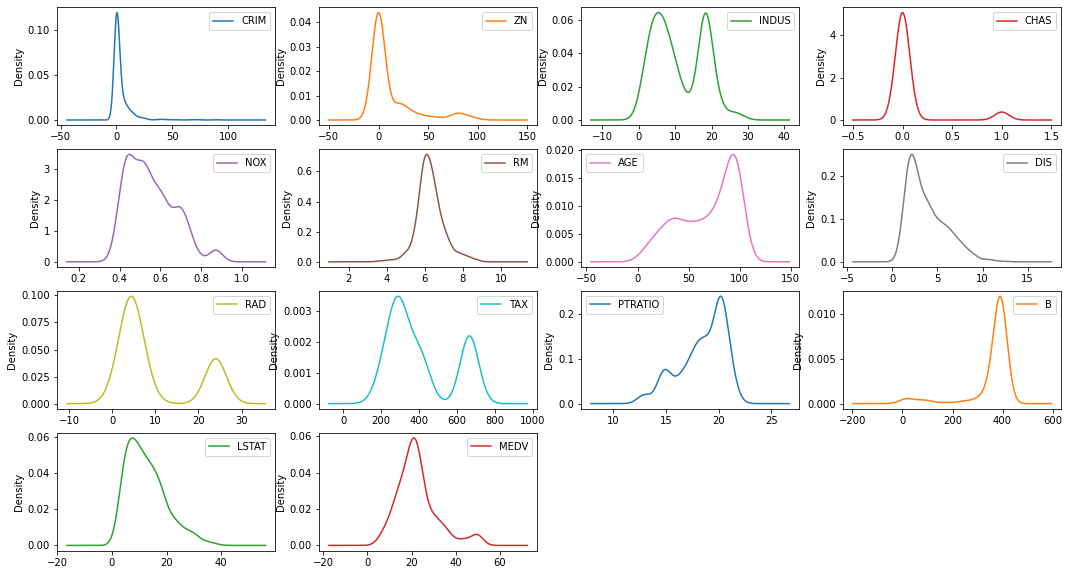

In [7]:
fig = df.plot(kind='density', subplots=True, layout=(4,4), sharex=False, figsize=(18, 10))

_Let us see outliers:_

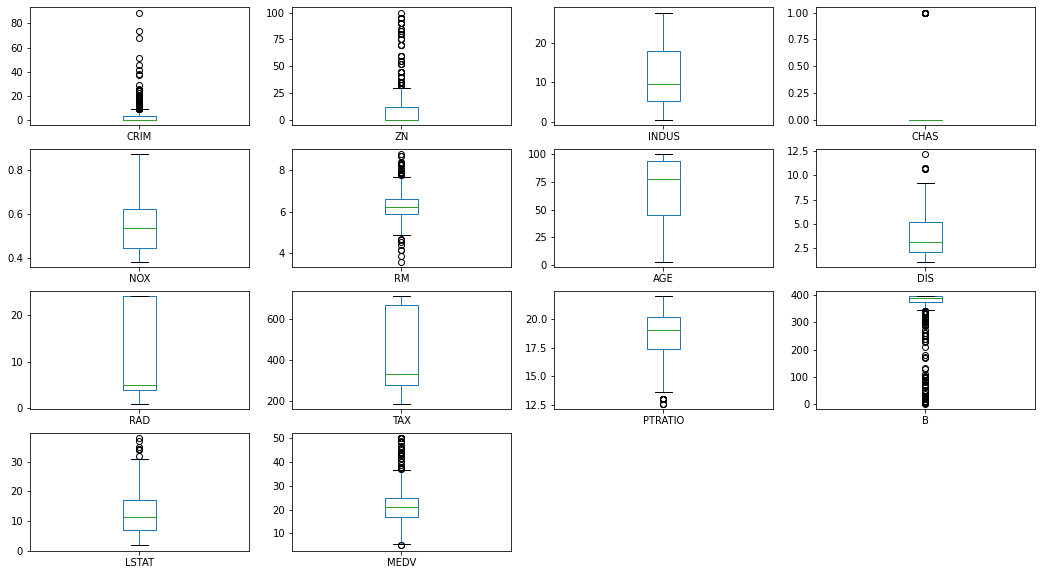

In [8]:
fig = df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(18, 10))

_Let us see correlations:_

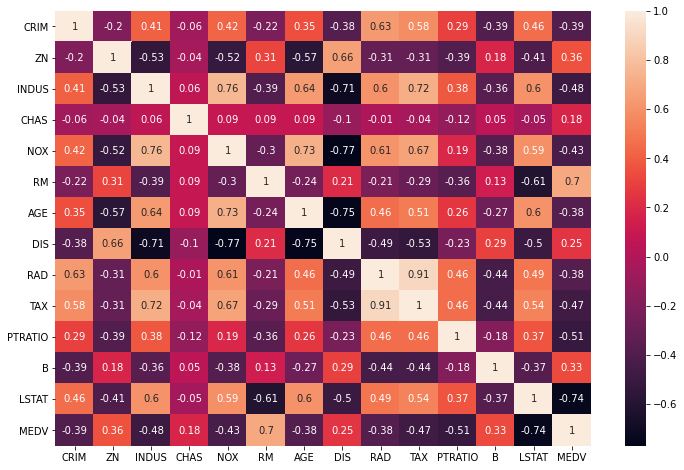

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
corr_matrix = df.corr().round(2)
fig = sns.heatmap(corr_matrix, annot=True, ax=ax)

Correlations might be worth seeing with our 'MEDV' label and 'LSTAT' feature. Here we see very well defined non-linear strong correlation, which is easily acceptable in practice, of course:

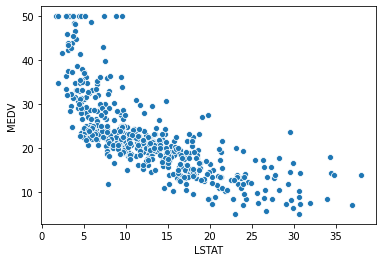

In [10]:
fig = sns.scatterplot(x=df['LSTAT'], y=df['MEDV'], data=df)

Also worth mentioning strong correlation with our 'MEDV' label and 'RM' feature with some outliers:

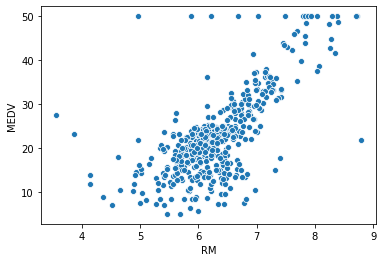

In [11]:
fig = sns.scatterplot(x=df['RM'], y=df['MEDV'], data=df)

Regarding to correlations between feature columns: we can see strong correlation between 'RAD' and 'TAX'. This can cause multicollinearity issues, but here we disregard it as we test many algorithms including non-linear ones and even ensembles.

#### Prepare data

All we do in this section is look for nulls. Here there are none:

In [12]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

#### Test harness

We use numerous cross-tests with SKLearn cross_val_score. In this section we set basic parameters and separate our test and validation sets:
* number of folds
* seed for models' comparability
* loss function
* validation set size

In [13]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'
validation_size = 0.20

array = df.values
X = array[:, 0:13]
Y = array[:, 13]
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#### Spot check algorithms

In [14]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(gamma='auto'))])))

#### Evaluate each model in turn

In [15]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -22.006009 (12.188886)
ScaledLASSO: -27.205896 (12.124418)
ScaledEN: -28.301160 (13.609110)
ScaledKNN: -21.456867 (15.016218)
ScaledCART: -24.708762 (15.996718)
ScaledSVR: -29.570433 (18.052964)


#### Compare algorithms

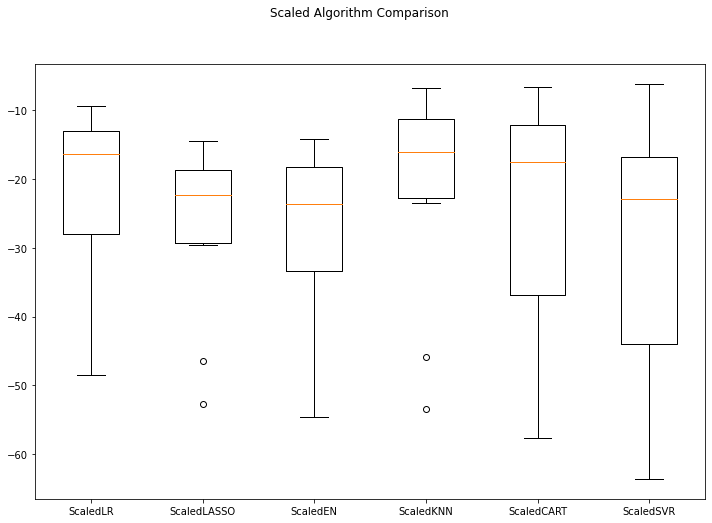

In [16]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Best model in KNN.

#### Scaled KNN algorithm tuning

In [17]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -19.532921 using {'n_neighbors': 1}
-19.532921 (15.809604) with: {'n_neighbors': 1}
-19.976746 (13.845123) with: {'n_neighbors': 3}
-21.270695 (14.877693) with: {'n_neighbors': 5}
-21.595627 (15.016710) with: {'n_neighbors': 7}
-21.021208 (14.769371) with: {'n_neighbors': 9}
-21.507995 (14.939525) with: {'n_neighbors': 11}
-21.280531 (14.522987) with: {'n_neighbors': 13}
-21.975913 (14.273897) with: {'n_neighbors': 15}
-22.746000 (14.553729) with: {'n_neighbors': 17}
-23.511412 (14.961989) with: {'n_neighbors': 19}
-24.241155 (15.212979) with: {'n_neighbors': 21}


c:\users\common\anaconda3\envs\ml-cpu-sk.0.21.2\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


KNN with k=3 seems to be to best (means, std) so far keeping in mind, that KNN with low k can be overfitted very easily.

#### Spot check ensembes algorithms

In [18]:
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=10))])))

#### Evaluate each ensemble model in turn

In [19]:
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: -15.579365 (8.468902)
ScaledGBM: -10.862849 (8.592951)
ScaledRF: -14.422546 (12.008833)
ScaledET: -9.749562 (6.140042)


#### Compare ensemble algorithms

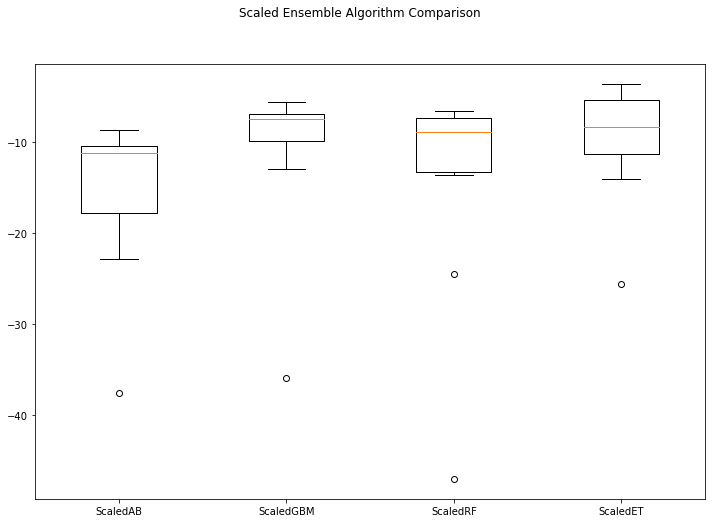

In [20]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Best ensemble model is ExtraTreeRegressor.

#### Tune scaled ExtraTreeRegressor

In [21]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50, 100, 150, 200, 250, 300, 350, 400]))
model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, iid=True)
grid_result = grid.fit(rescaledX, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -9.058011 using {'n_estimators': 150}
-9.219204 (6.684859) with: {'n_estimators': 50}
-9.205721 (6.811229) with: {'n_estimators': 100}
-9.058011 (6.559097) with: {'n_estimators': 150}
-9.072659 (6.535453) with: {'n_estimators': 200}
-9.093935 (6.603940) with: {'n_estimators': 250}
-9.079155 (6.601491) with: {'n_estimators': 300}
-9.076014 (6.537140) with: {'n_estimators': 350}
-9.108577 (6.560285) with: {'n_estimators': 400}


150 seems to be the best for n_estimators hyperparameter.

#### Make predictions on validation dataset

Ensemble methods performed better than KNN. Best is ExtraTreeRegressor with n_estimators=150.

#### Prepare the model

In [22]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = ExtraTreesRegressor(n_estimators=150)
model.fit(rescaledX, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

#### Make prediction

In [23]:
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print("validation set's mse: %.2f" % mean_squared_error(y_validation, predictions))

validation set's mse: 13.41


In [24]:
r2 = r2_score(y_validation, predictions)
print("validation set's r2_score: %.2f" % r2)

validation set's r2_score: 0.83
